In [1]:
# Common imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap

# To make this notebook's output stable across runs
np.random.seed(255)

#To ignore future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

### Useful functions

In [2]:
colormap_label_0 = {"0": "blue", "1": "darkorange", "2": "red", "3": "green"}

In [3]:
def import_clustered_data(path):

    #Import the 4 TiMeS datasets corresponding to each time point, add time feature
    data_0 = pd.read_csv(path+str(0)+'.csv').drop(columns=['Unnamed: 0']).assign(time="0").assign(time_in_weeks=1)
    data_1 = pd.read_csv(path+str(1)+'.csv').drop(columns=['Unnamed: 0']).assign(time="1").assign(time_in_weeks=3)
    data_2 = pd.read_csv(path+str(2)+'.csv').drop(columns=['Unnamed: 0']).assign(time="2").assign(time_in_weeks=12) #12 weeks = 3 months
    data_3 = pd.read_csv(path+str(3)+'.csv').drop(columns=['Unnamed: 0']).assign(time="3").assign(time_in_weeks=52) #52 weeks = 1 year

    #Merge the 4 TiMeS datasets in one
    data = pd.concat([data_0, data_1, data_2, data_3])

    #Change label column type for statistics purposes
    data['Labels'] = data['Labels'].astype(str)

    #Add label at time 0 feature
    data["Label_0"] = data.apply(lambda x: data_0[data_0["Patient"]==x["Patient"]]["Labels"].values[0].astype(str) if any(data_0["Patient"]==x["Patient"]) else np.nan, axis=1)

    return data, data_0

def import_group_clustered_data(name, cluster_types):

    #create dictionary to store dataframe of each type
    datas = {}

    for type in cluster_types.keys():

        # modify path to include type
        path = name + type

        #import data
        data, data_0 = import_clustered_data(path)

        #For cluster comparison, create a new dataframe with only Patient, Time and Labels features merged for all types
        data["Type"] = cluster_types[type]
        datas[type] = data
        if type == list(cluster_types.keys())[0]:
            compare_clusters = data[["Patient","Label_0", "time","time_in_weeks","motor"]]
        else:
            compare_clusters = compare_clusters.merge(data[["Patient","Label_0","time","motor"]], on=["Patient","time"], suffixes=('', type))
        #display(compare_clusters)
    

    compare_clusters.rename(columns={"Label_0": "Label_0" + list(cluster_types.keys())[0], "motor":"motor"+ list(cluster_types.keys())[0]}, inplace=True)
    # Merge the dictionary of dataframes in one
    merged_datas = pd.concat(datas.values())
    
    return merged_datas, datas, compare_clusters

def comparison(compare_clusters, label0, label1, title):
    info = compare_clusters.groupby([label0, label1]).size().unstack(fill_value=0)
    display(info)

    fig, ax = plt.subplots(1, 3, figsize=(21,5))

    # Create a custom colormap to highlight 0 values
    colors = sns.color_palette("YlGnBu", 256)
    colors[0] = (1, 1, 1)  # Set color for value 0 to white
    custom_cmap = ListedColormap(colors)

    # Create a heatmap
    sns.heatmap(info, annot=True, fmt='d', cmap=custom_cmap, ax=ax[0], cbar_kws={'label': 'Number of patients'}, vmin=0)
    ax[0].set_title('Number of common patients between clusters of the 2 different clustering', fontsize=9)

    total = info.sum(axis=1)
    percentage_info = info.div(total, axis=0)

    # Create a heatmap
    sns.heatmap(percentage_info, annot=True, fmt='.0%', cmap=custom_cmap, ax=ax[1], cbar_kws={'label': '% patients with Labels in Labels_merge cluster'})
    ax[1].set_title('Percentage of common patients between clusters of the 2 different clustering', fontsize=9)
    
    total = info.sum(axis=0)
    percentage_info = info.div(total, axis=1) 

    # Create a heatmap
    sns.heatmap(percentage_info, annot=True, fmt='.0%', cmap=custom_cmap, ax=ax[2], cbar_kws={'label':'% of patients with Labels_merge in Labels cluster'})
    ax[2].set_title('Percentage of common patients between clusters of the 2 different clustering', fontsize=9)

    plt.suptitle(title, fontsize=12)
    plt.show()

def lineplot_comparison(data, type0, type1, figsize=(15, 6)):

    plt.figure(figsize=figsize)
    sns.lineplot(data=data, x="time_in_weeks", y="motor"+type0, hue="Label_0"+type0, style="Label_0"+type1, palette=colormap_label_0, estimator =None, units="Patient") 
    plt.xlabel("Time (in weeks)")
    plt.title("Motor recovery per cluster per time point")
    plt.show();



## Objective : 
## Compare clustering with/without last score test for language & with merged/seperate executive and memory cognitive domains

In [4]:
domains = ["motor", "attention", "executive", "sensory", "language", "neglect", "memory"]
specific_domains = ["motor", "language","executive", "memory"]
n_domains = len(domains)
cluster_types = {"_merge_": "merge executive and meomry, last_scores not included", "_merge_LAST_":"merge executive and meomry, last_scores included", "_":"seperate executive and memory, last_scores not included", "_LAST_":"seperate executive and memory, last_scores included "}

### Preprocessing

In [5]:
path = r'../Lisa/NMF_per_timepoint'
merged_NMFs, NMFs, compare_clusters = import_group_clustered_data(path, cluster_types)
display(merged_NMFs)

,motor,attention,executive,sensory,language,neglect,Patient,Labels,time,time_in_weeks,Label_0,Type,memory
0,0.003716,0.194499,0.295743,0.000000,0.288797,0.056766,P001,0,0,1,0,"merge executive and meomry, last_scores not in...",NaN
1,0.036073,0.179785,0.332524,0.000000,0.210102,0.037255,P002,0,0,1,0,"merge executive and meomry, last_scores not in...",NaN
2,0.025385,0.260306,0.366695,0.000000,0.305543,0.017137,P003,0,0,1,0,"merge executive and meomry, last_scores not in...",NaN
3,0.011965,0.221951,0.386690,0.033708,0.319733,0.126463,P004,0,0,1,0,"merge executive and meomry, last_scores not in...",NaN
4,0.014486,0.314425,0.337978,0.000000,0.279560,0.078781,P005,0,0,1,0,"merge executive and meomry, last_scores not in...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41,0.020496,0.252341,0.307077,0.000000,0.300056,0.024519,P076,0,3,52,1,"seperate executive and memory, last_scores inc...",0.362504
42,0.035450,0.246121,0.518474,0.000000,0.339490,0.014666,P077,1,3,52,1,"seperate executive and memory, last_scores inc...",0.362504
43,0.031642,0.429661,0.374896,0.000000,0.341137,0.088666,P079,1,3,52,NaN,"seperate executive and memory, last_scores inc...",0.297328
44,0.005167,0.054245,0.223163,0.000000,0.197545,0.011024,P081,0,3,52,0,"seperate executive and memory, last_scores inc...",0.275602


### Evolution of clusters defined at time 0 for each clustering

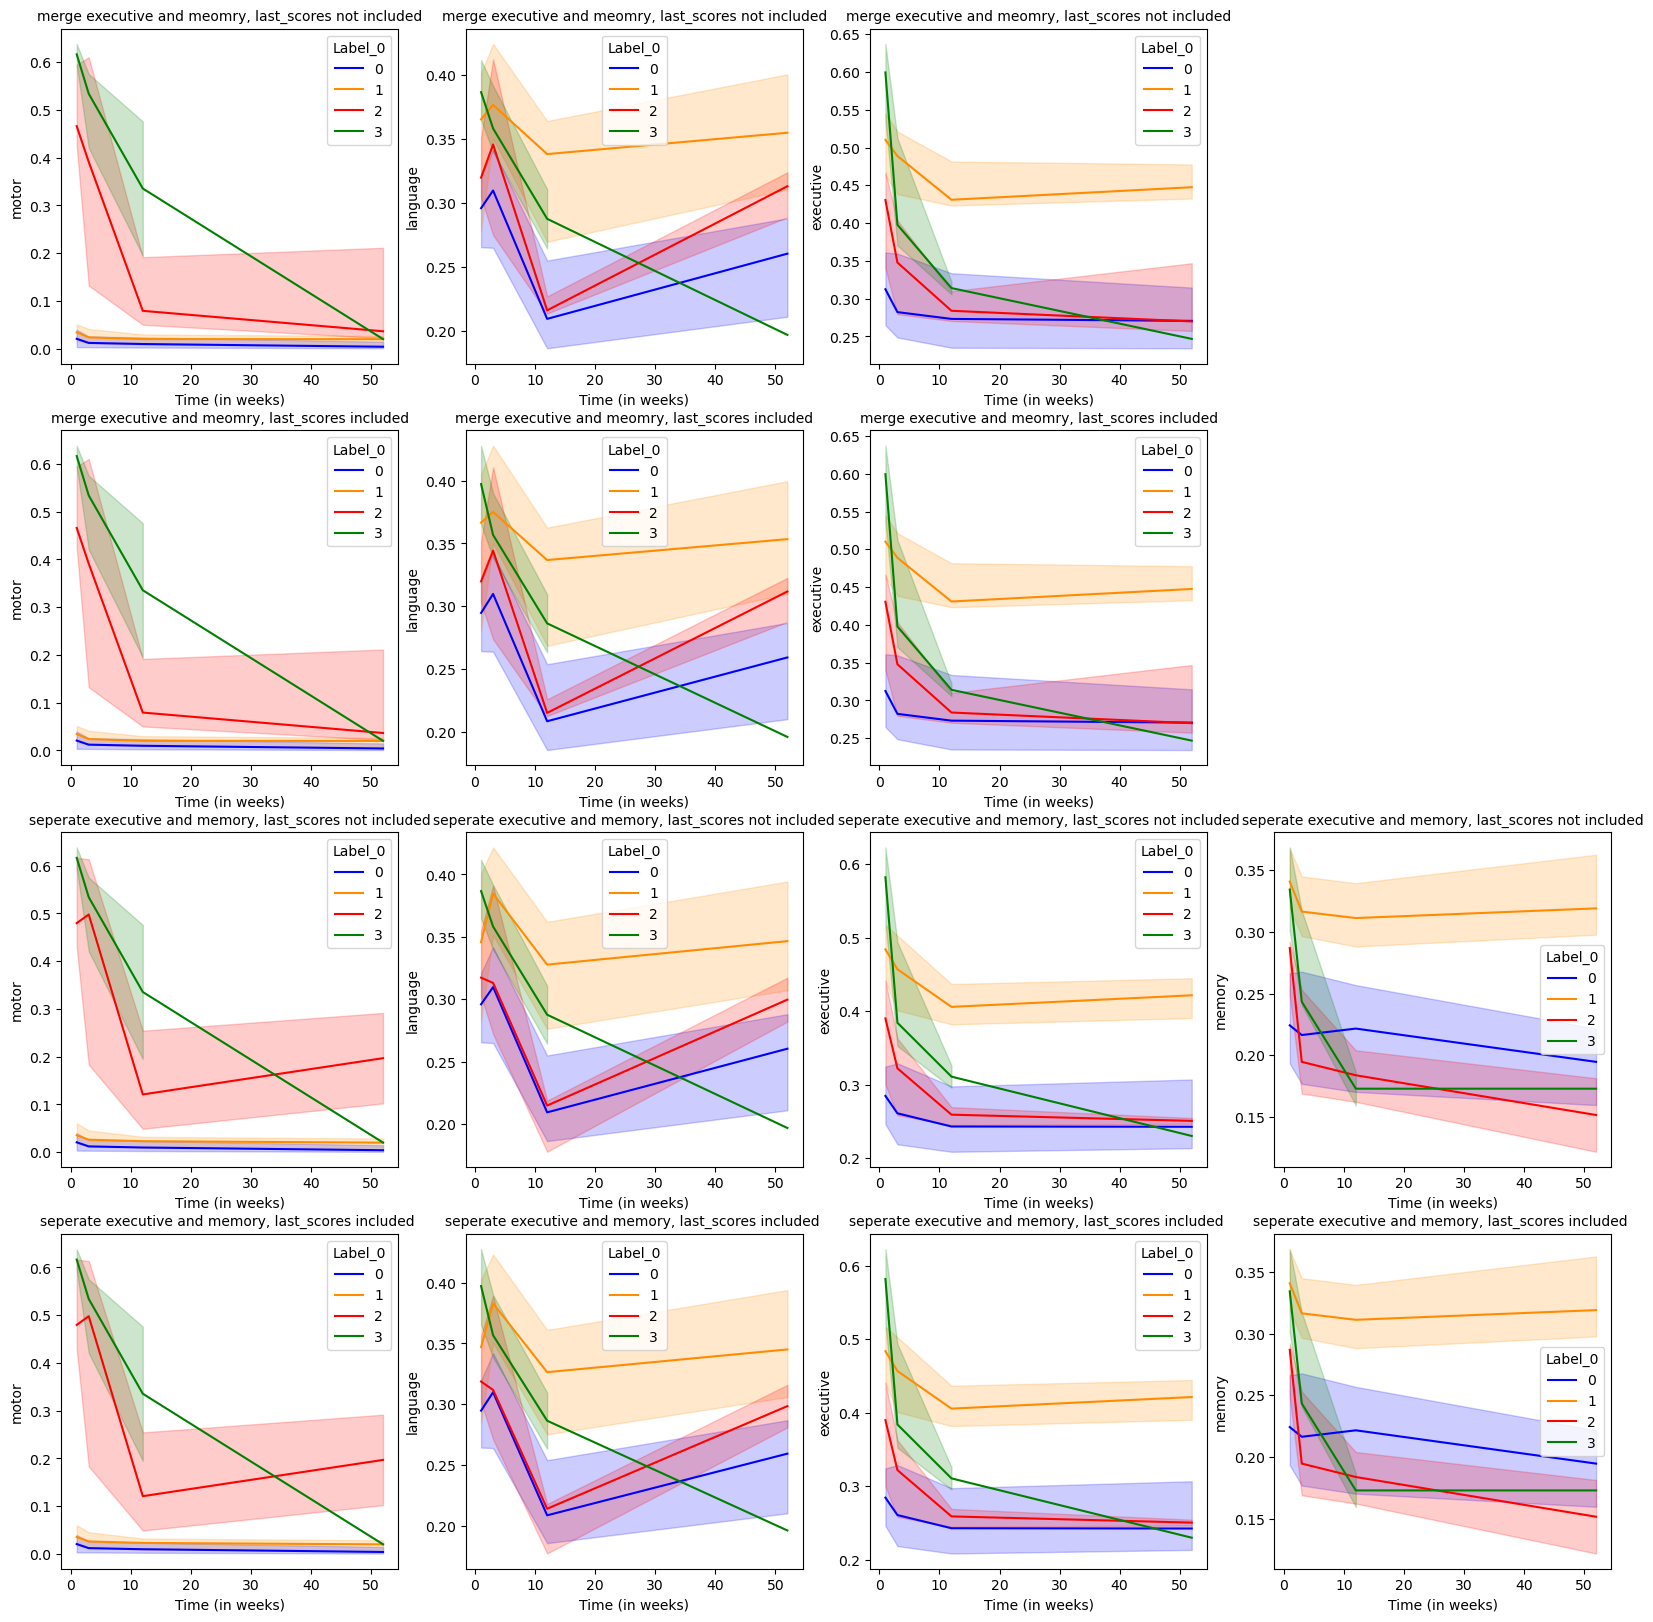

In [6]:
fig, ax = plt.subplots(len(specific_domains), len(cluster_types), figsize=(20,20))
for j,type in enumerate(cluster_types.keys()):
    NMF = NMFs[type]
    for i, domain in enumerate(specific_domains):
        if domain in NMF.columns:
            sns.lineplot(data=NMF, x="time_in_weeks", y=domain, ax=ax[j, i], estimator = "median", errorbar=("pi", 50), hue="Label_0", palette=colormap_label_0)
            ax[j,i].set_xlabel("Time (in weeks)")
            ax[j,i].set_title(cluster_types[type], fontsize=10)
        else:
            ax[j, i].axis('off')  # Hide the subplot if domain not present
        

We can observe that the overall behaviour of the clusters of each domain seem to be the same for datasets including the last scores language test and datasets not including it. \
However, in every shown domains we can see differences between clusters for datasets with merge executive and memory domains and datasets with executive and memory unmerged 

In [7]:
#Check if dataframes including language last score test and dataframes without are different
print(NMFs["_"].equals(NMFs["_LAST_"])) # As expected, those 2 dataframes are different

False


Since clustering is done at time 0, let's observe differences in median and interquartile range values at time 0 for each chosen domain

### Performance boxplots at time 0 for each clustering

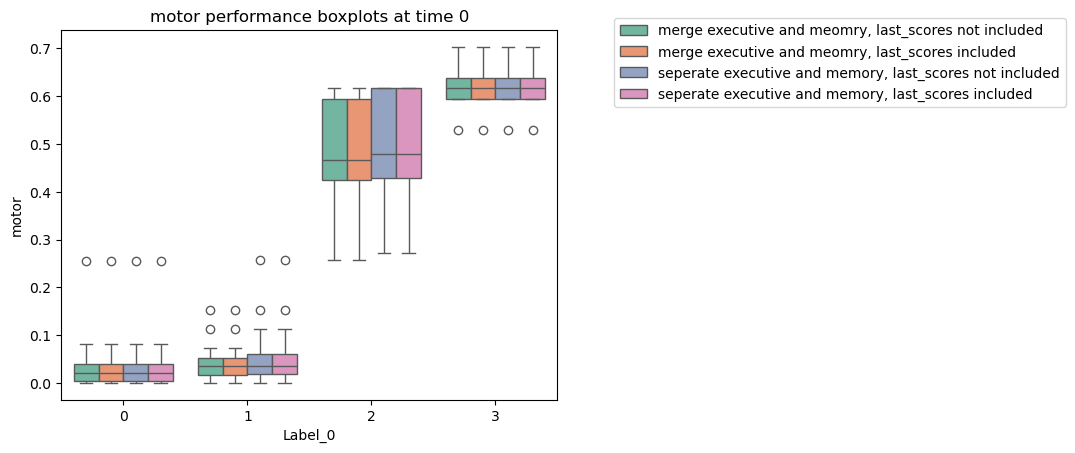

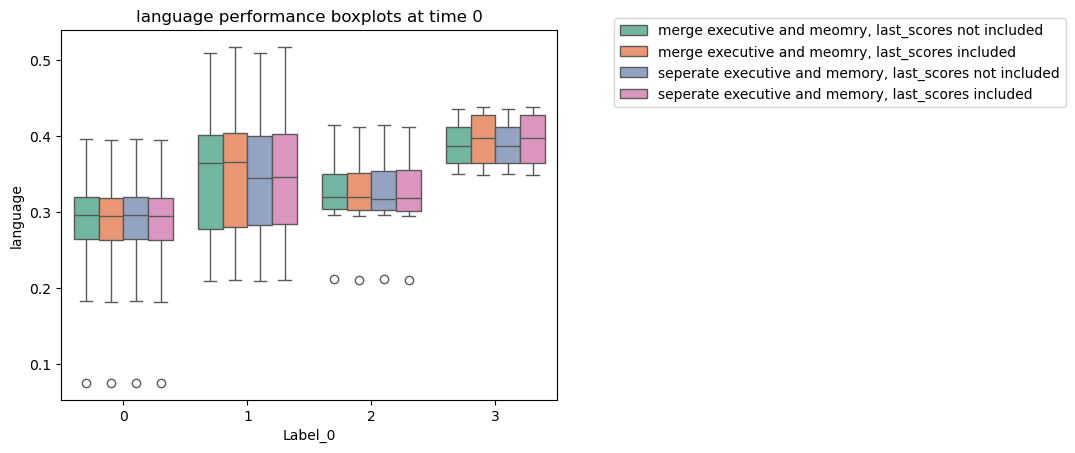

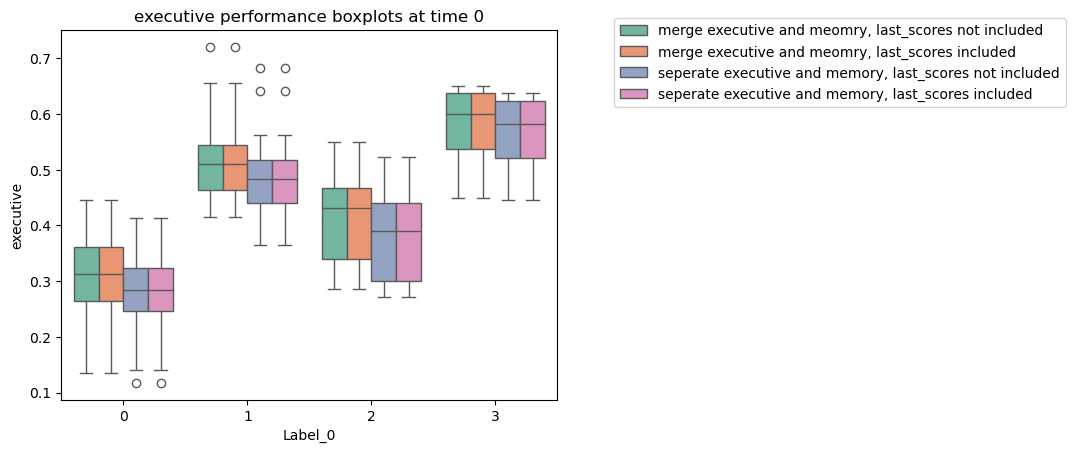

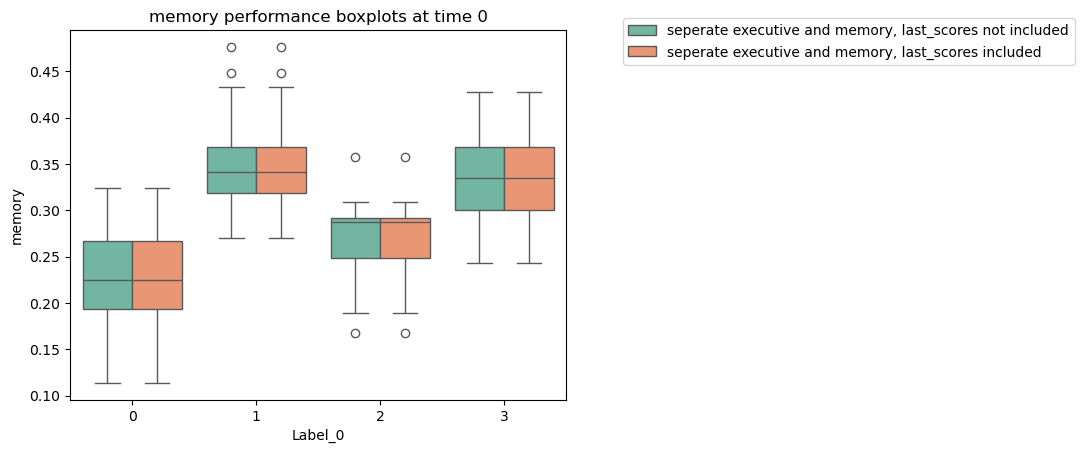

In [8]:
#To ignore runtime warnings for memory plot
#warnings.filterwarnings("ignore", category=RuntimeWarning)

for i, domain in enumerate(specific_domains[:-1]):
    ax = sns.boxplot(data=merged_NMFs[merged_NMFs["time"]=="0"], x="Label_0", y=domain, hue="Type", palette=sns.color_palette("Set2"))
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.title(domain +" performance boxplots at time 0")
    plt.show()

data = merged_NMFs[(merged_NMFs["time"] == "0") & 
                   ((merged_NMFs["Type"] == cluster_types["_"]) |
                    (merged_NMFs["Type"] == cluster_types["_LAST_"]))]

ax = sns.boxplot(data=data, x="Label_0", y=specific_domains[-1], hue="Type", palette=sns.color_palette("Set2"))
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title(specific_domains[-1] +" performance boxplots at time 0")
plt.show()
    

Label_0_LAST_,0,1,2,3
Label_0_,,,,
0,40,0,0,0
1,0,21,0,0
2,0,0,9,0
3,0,0,0,4


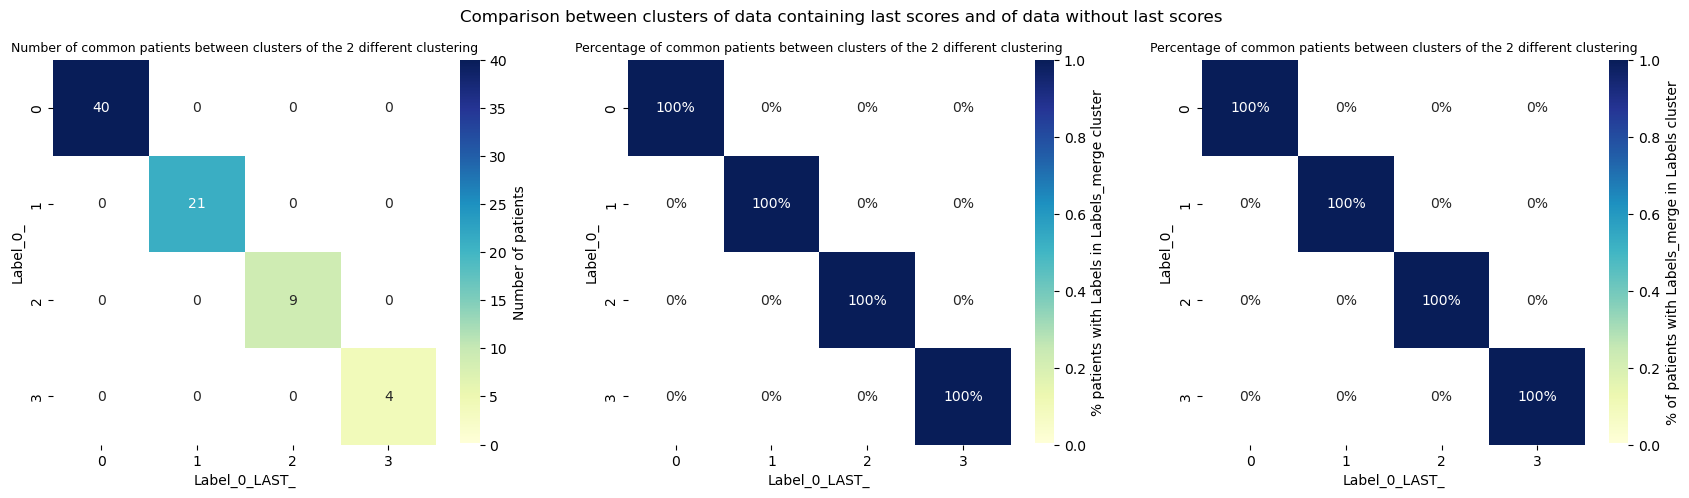

Label_0_merge_,0,1,2,3
Label_0_,,,,
0,40,0,0,0
1,0,20,1,0
2,0,0,9,0
3,0,0,0,4


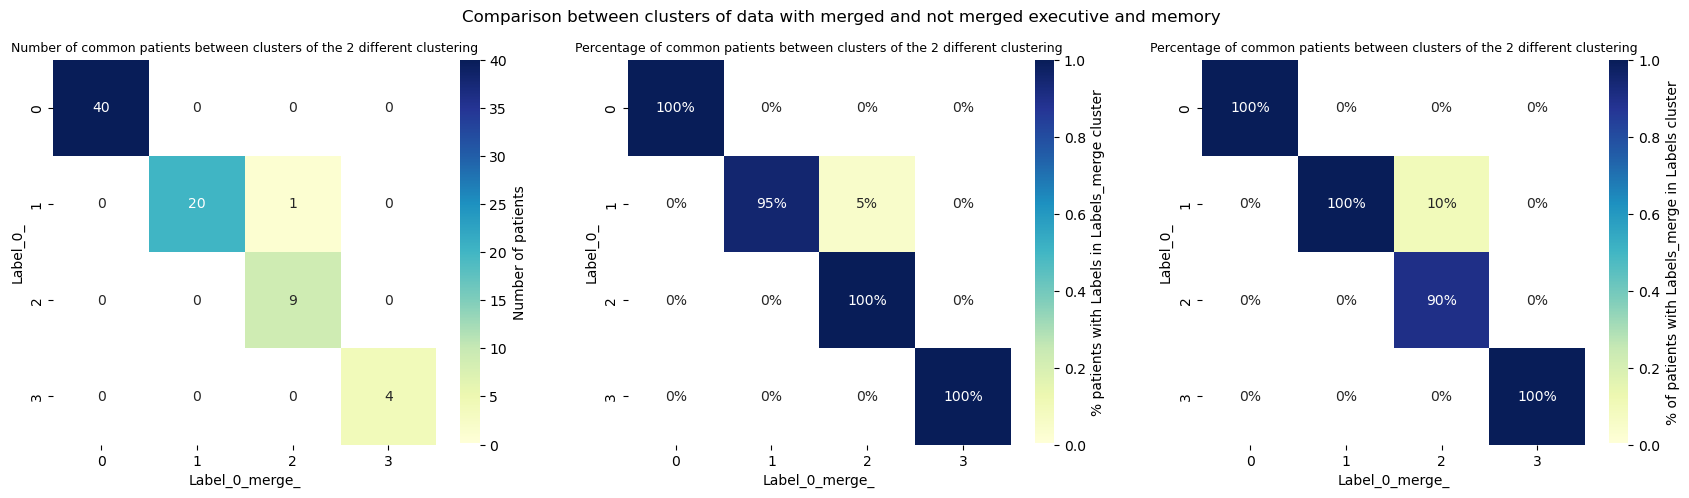

In [9]:
# Comparison between clusters of data containing last scores and not containing last scores
title="Comparison between clusters of data containing last scores and of data without last scores"
comparison(compare_clusters[compare_clusters["time"]== "0"], 'Label_0_', 'Label_0_LAST_', title)

#Comparison between clusters of data with merged and not merged executive and memory 
title="Comparison between clusters of data with merged and not merged executive and memory"
comparison(compare_clusters[compare_clusters["time"]== "0"], 'Label_0_', 'Label_0_merge_', title)

## Objective : 
## Compare clustering with MOCA total only for cognitive vs with every MOCA tests for cognitive (Fugi Meyer test used for motor performance)

In [10]:
cluster_types = {"_2features_" : "No NMF 2features", "_MOCA_" : "No NMF MOCA"}

### Preprocessing

In [11]:
path = r'../Lisa/Without_NMF'
merged_datas, datas, compare_clusters2 = import_group_clustered_data(path, cluster_types)

simple_domains = list(datas["_2features_"].columns[1:-5])
moca_domains = list(datas["_MOCA_"].columns[1:-5])

compare_clusters = compare_clusters.merge(compare_clusters2.drop(["time_in_weeks"], axis=1), on=["Patient", "time"])
display(compare_clusters)

,Patient,Label_0_merge_,time,time_in_weeks,motor_merge_,Label_0_merge_LAST_,motor_merge_LAST_,Label_0_,motor_,Label_0_LAST_,motor_LAST_,Label_0_2features_,motor_2features_,Label_0_MOCA_,motor_MOCA_
0,P001,0,0,1,0.003716,0,0.003716,0,0.003716,0,0.003716,0,0.008547,0,0.008547
1,P002,0,0,1,0.036073,0,0.036073,0,0.036073,0,0.036073,0,0.008696,0,0.008696
2,P003,0,0,1,0.025385,0,0.025385,0,0.025385,0,0.025385,0,0.000000,0,0.000000
3,P004,0,0,1,0.011965,0,0.011965,0,0.011965,0,0.011965,0,0.000000,0,0.000000
4,P005,0,0,1,0.014486,0,0.014486,0,0.014486,0,0.014486,0,0.008403,0,0.008403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,P076,1,3,52,0.020496,1,0.020496,1,0.020496,1,0.020496,0,0.000000,1,0.000000
232,P077,1,3,52,0.035450,1,0.035450,1,0.035450,1,0.035450,0,0.030303,1,0.030303
233,P079,NaN,3,52,0.031642,NaN,0.031642,NaN,0.031642,NaN,0.031642,NaN,0.035714,NaN,0.035714
234,P081,0,3,52,0.005167,0,0.005167,0,0.005167,0,0.005167,0,0.000000,0,0.000000


### Evolution of clusters defined at time 0 for each clustering

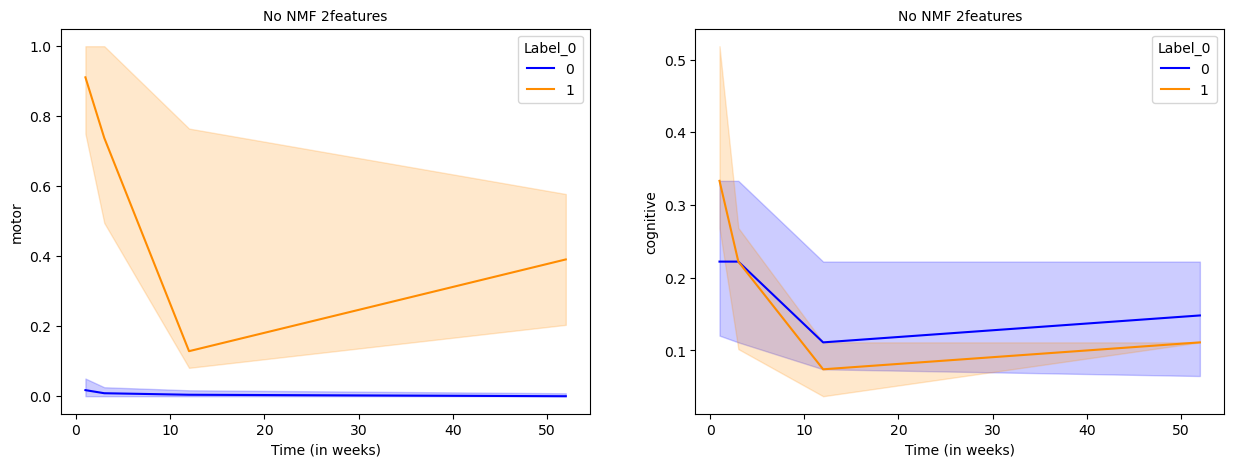

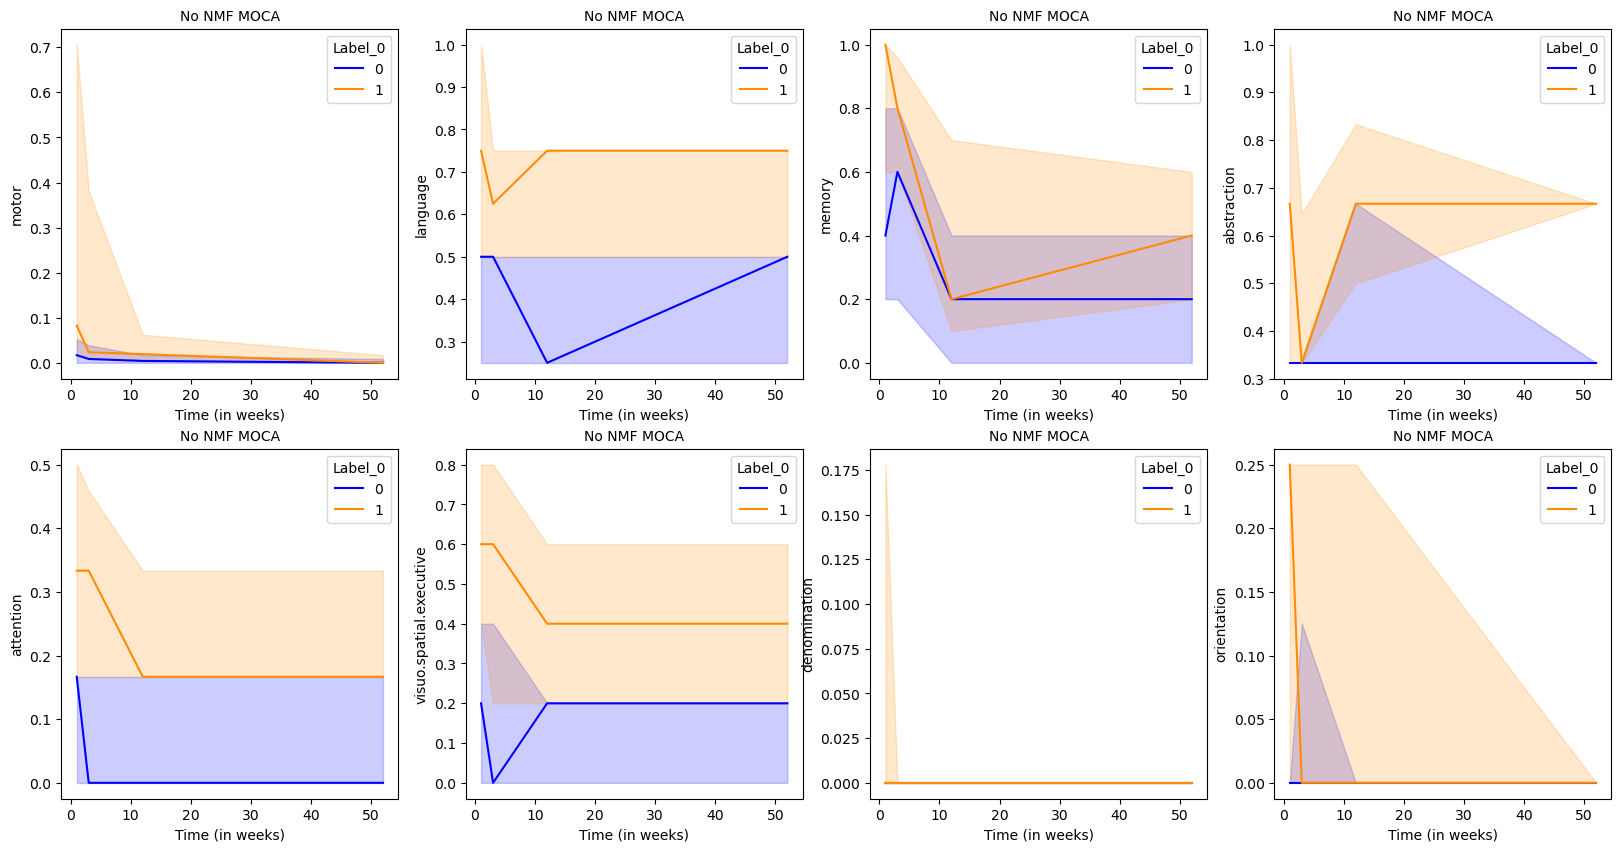

In [12]:
fig, ax = plt.subplots(1, len(simple_domains), figsize=(15,5))
type = "_2features_"
for i, domain in enumerate(simple_domains):
    sns.lineplot(data=datas[type], x="time_in_weeks", y=domain, ax=ax[i], estimator = "median", errorbar=("pi", 50), hue="Label_0", palette=colormap_label_0)
    ax[i].set_xlabel("Time (in weeks)")
    ax[i].set_title(cluster_types[type], fontsize=10)
plt.show()

fig, ax = plt.subplots(2, 4, figsize=(20,10))
type = "_MOCA_"
for i, domain in enumerate(moca_domains):
    sns.lineplot(data=datas[type], x="time_in_weeks", y=domain, ax=ax[i%2, i//2], estimator = "median", errorbar=("pi", 50), hue="Label_0", palette=colormap_label_0)
    ax[i%2, i//2].set_xlabel("Time (in weeks)")
    ax[i%2, i//2].set_title(cluster_types[type], fontsize=10)

Label_0_MOCA_,0,1
Label_0_2features_,,
0,46,16
1,3,9


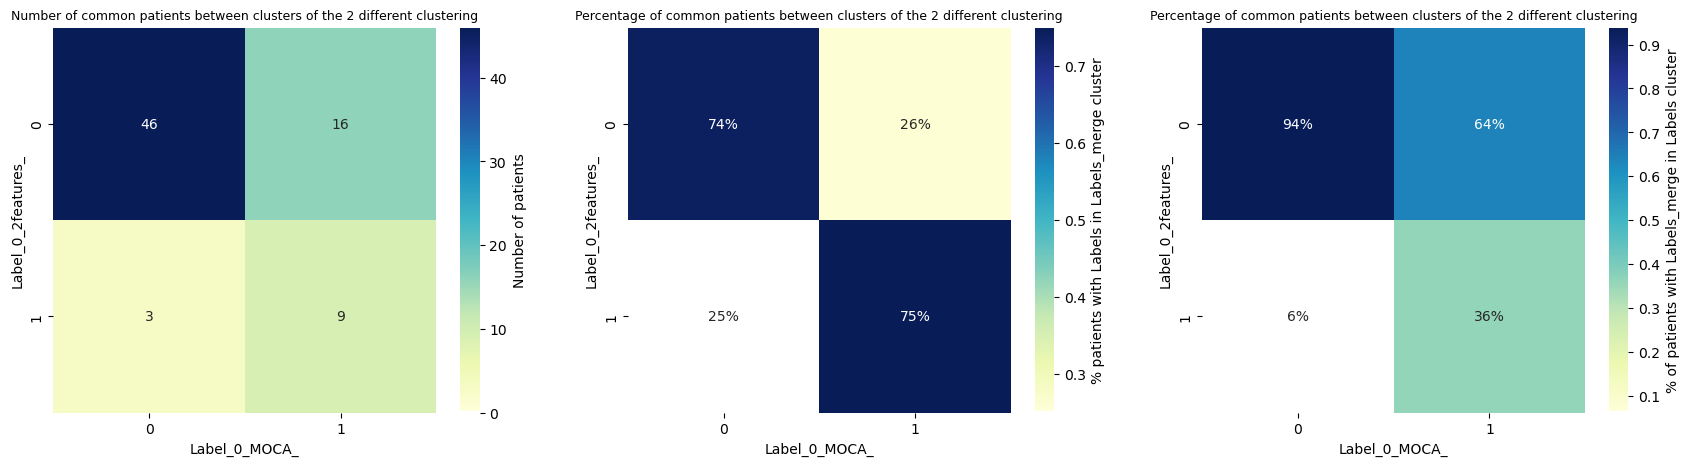

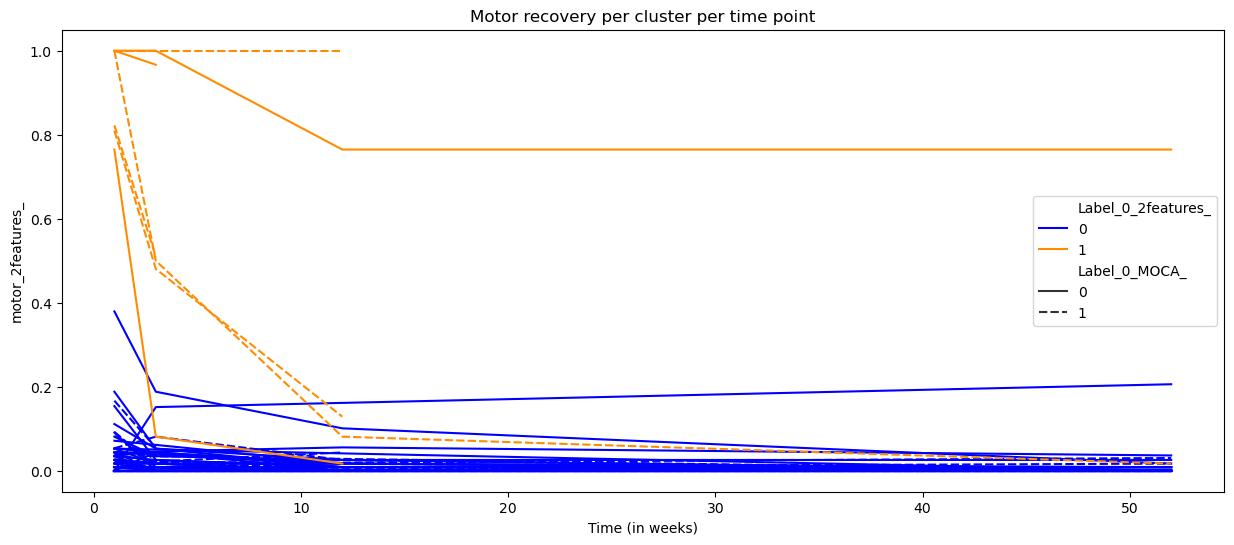

In [13]:
# Comparison between clusters of data containing last scores and not containing last scores
title=""
comparison(compare_clusters[compare_clusters["time"]== "0"], 'Label_0_2features_', 'Label_0_MOCA_', title)
lineplot_comparison(compare_clusters, '_2features_', '_MOCA_')


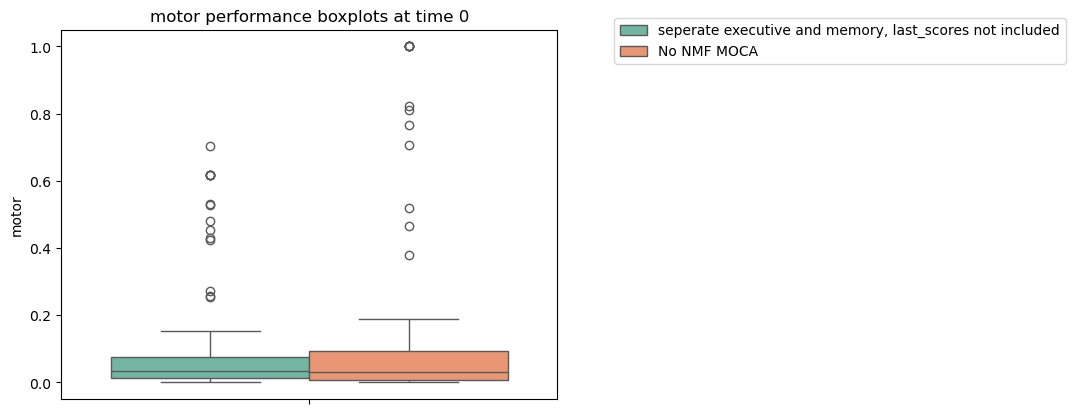

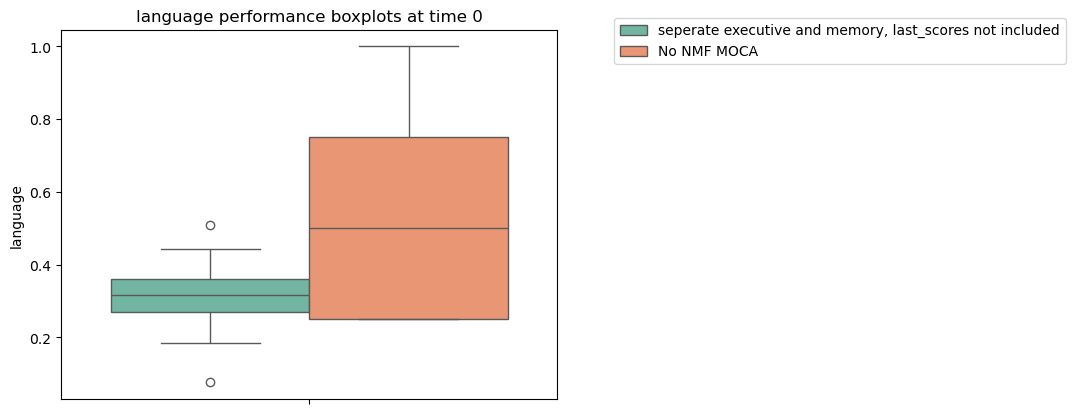

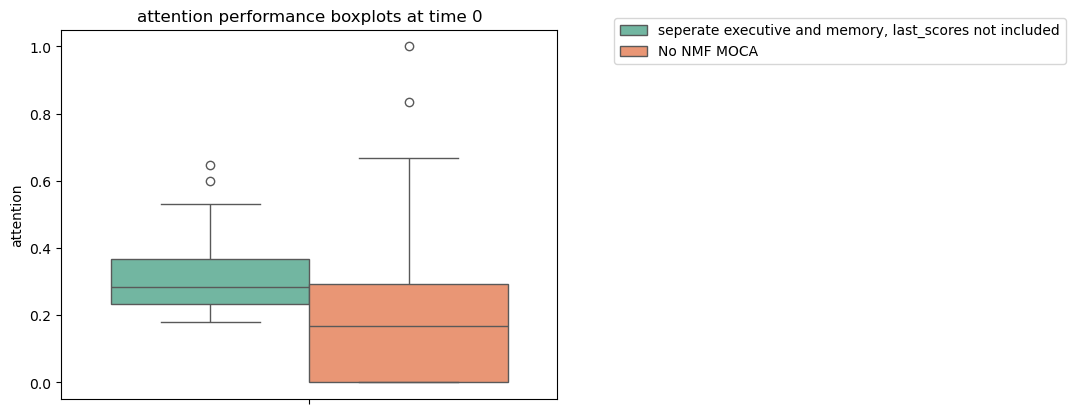

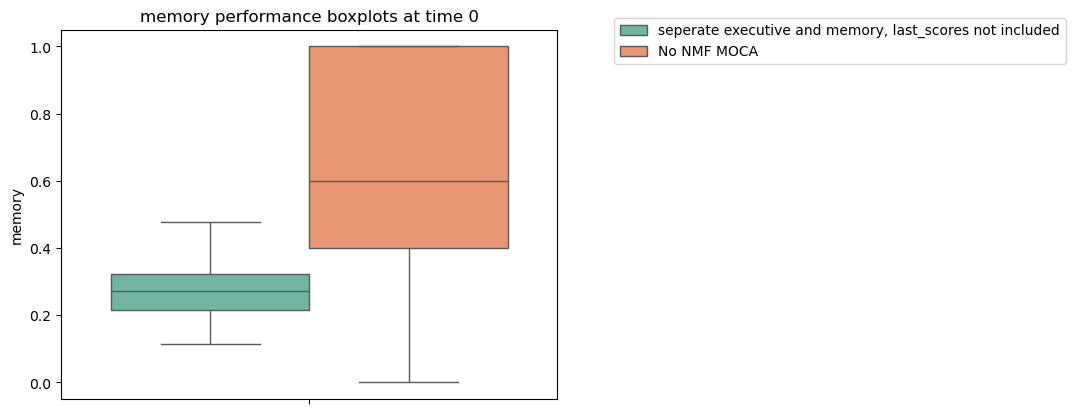

In [19]:
merge = pd.concat([merged_NMFs, merged_datas])
merge_0 = merge[merge["time"]=="0"]
specific_data = merge_0[merge_0["Type"].isin(["seperate executive and memory, last_scores not included", "No NMF MOCA"])]
specific_domains = ["motor", "language", "attention", "memory"]

for i, domain in enumerate(specific_domains):
    ax = sns.boxplot(data=specific_data, hue="Type", y=domain, palette=sns.color_palette("Set2"))
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.title(domain +" performance boxplots at time 0")
    plt.show()

La distribution des valeurs des performances de langage, de mémoire et d'attention sont très différents entre les 2 types de clusters. \
La distribution des performances motrices est très similaire entre les 2 types de cluster. 

Observons donc les differences des distributions des clusters pour le domaine moteur au temps 0.

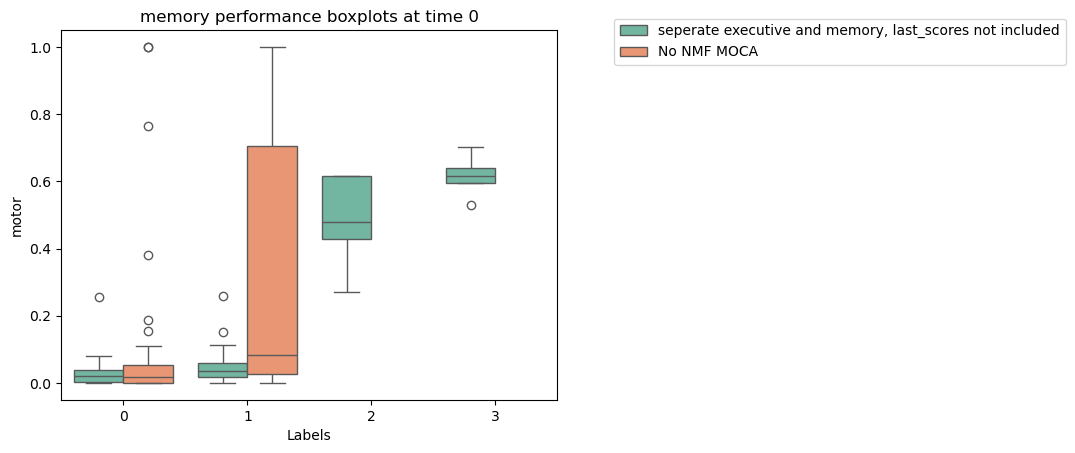

In [21]:

sns.boxplot(data=specific_data, x="Labels", y="motor", hue="Type", palette=sns.color_palette("Set2"))
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title(domain +" performance boxplots at time 0")
plt.show()

Les clusters 0 semblent relativement identiques, tandis que le cluster 1 du "No NMF MOCA" semble rassembler l'ensemble des cluster 1,2 et 3 du "seperate executive and memory"

Label_0_merge_,0,1,2,3
Label_0_MOCA_,,,,
0,38,6,5,0
1,2,14,5,4


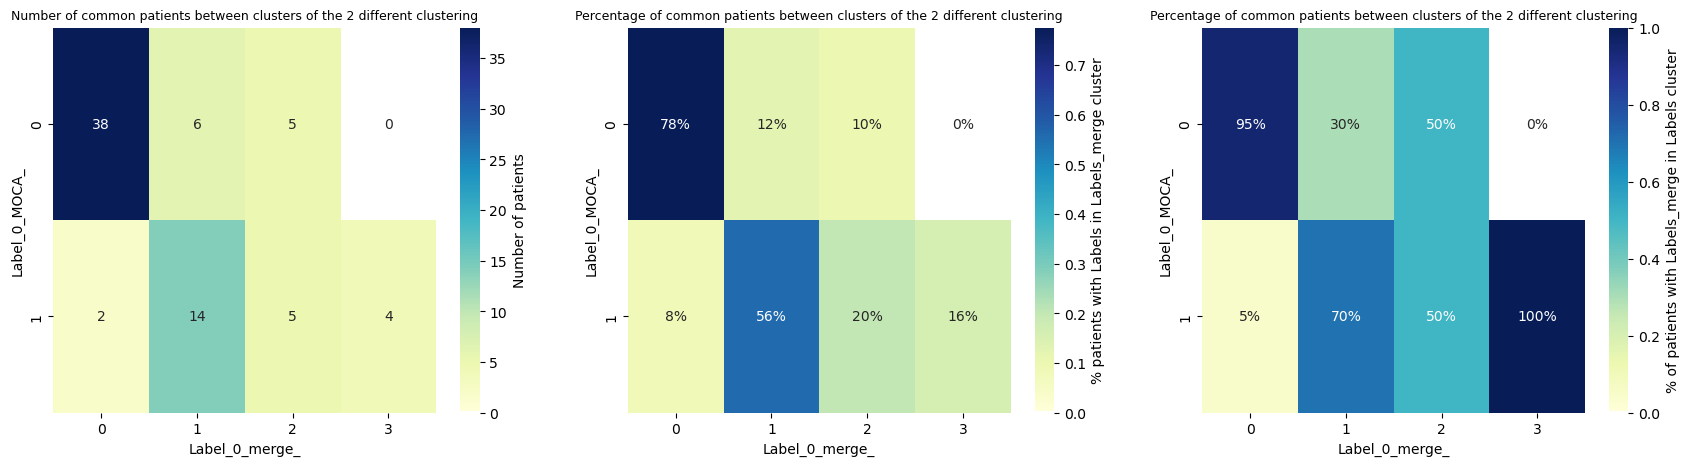

In [16]:
comparison(compare_clusters[compare_clusters["time"]== "0"], 'Label_0_MOCA_', 'Label_0_merge_', title)
# lineplot_comparison(compare_clusters,'_merge_', '_MOCA_')

Effectivement grosse similarité entre les clusters 0 des deux types de cluster

Label_0_merge_,0,1,2,3
Label_0_2features_,,,,
0,40,20,2,0
1,0,0,8,4


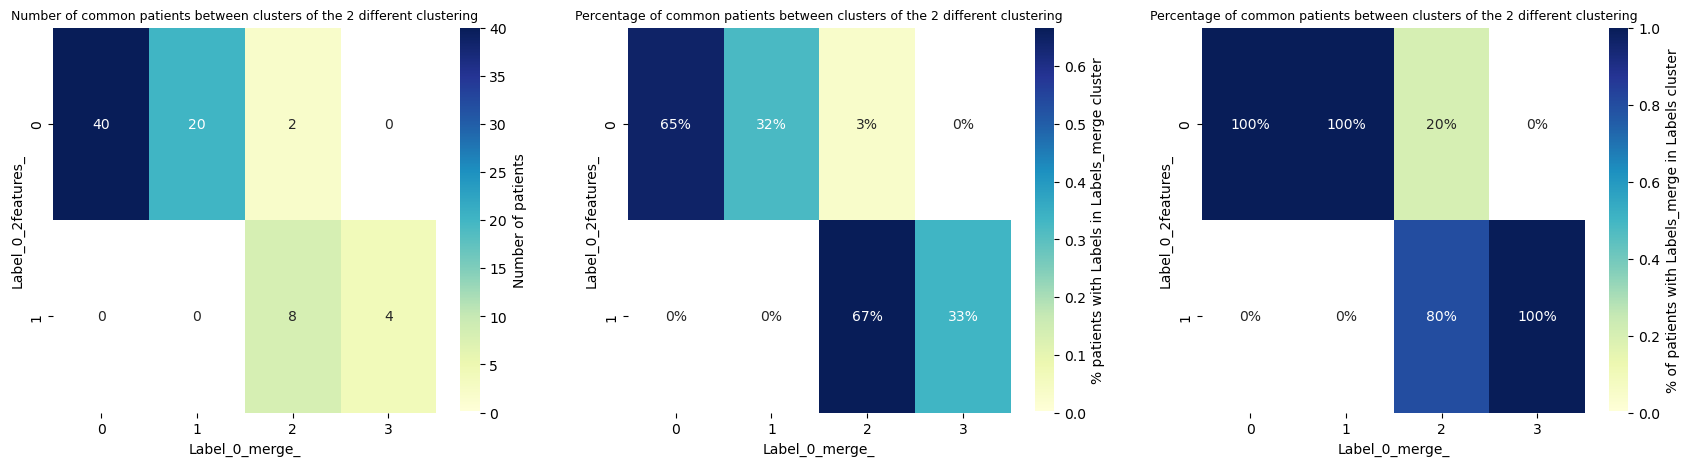

In [22]:
comparison(compare_clusters[compare_clusters["time"]== "0"], 'Label_0_2features_', 'Label_0_merge_', title)
#lineplot_comparison(compare_clusters, '_2features_', '_merge_')
#lineplot_comparison(compare_clusters, '_merge_', '_2features_')"""